<a href="https://colab.research.google.com/github/zahraDehghanian97/Brain_cancer_classification/blob/master/Brain_Tumor_MRI_Image_Classification_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detection and Classification of Brain Tumor through Brain MRI Images Using Deep Learning**  

## **2. Setting Up Local Storage for Dataset**

### **2.1 Giving Access To Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## **3. Importing Required Libraries**

In [2]:
import sys
import os
import math
import h5py
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import keras
from tensorflow.keras.preprocessing.image import *
 
print(f'Tensorflow Version: {tf.__version__}.')

Tensorflow Version: 2.9.2.


### **4.3 Setting Up Paths to Root and Data Directories**

In [4]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer')
!ls     

#Create a directory named dataset
!mkdir dataset
!ls -a

dataset


In [5]:
#Download Files
from google.colab import files
import requests 
file_url = "https://ndownloader.figshare.com/articles/1512427/versions/5"
	
r = requests.get(file_url, stream = True) 

with open("/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/data.zip", "wb") as file: 
	for block in r.iter_content(chunk_size = 1024): 
		if block: 
			file.write(block) 


In [6]:

##Unzip data
!unzip -q data.zip -d dataset/


In [7]:
import zipfile
with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/dataset/brainTumorDataPublic_1-766.zip', 'r') as zip_ref:
   zip_ref.extractall('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/Training')
with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/dataset/brainTumorDataPublic_767-1532.zip', 'r') as zip_ref:
   zip_ref.extractall('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/Training')
with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/dataset/brainTumorDataPublic_1533-2298.zip', 'r') as zip_ref:
   zip_ref.extractall('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/Training')
with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/dataset/brainTumorDataPublic_2299-3064.zip', 'r') as zip_ref:
   zip_ref.extractall('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/Training')


In [8]:
def mat_file_to_dict(filepath: str) -> dict:
    tumor_class = {1: 'meningioma', 2: 'glioma', 3: 'pituitary_tumor'}
    tumor_data_dict = {}
    with h5py.File(filepath, mode = 'r') as image_data:
        cjdata_struct = image_data['cjdata']
        id  = ""
        for i in range (len(cjdata_struct['PID'])):
          id = id+str(cjdata_struct['PID'][i][0])
        tumor_data_dict['PID'] = int(id)
        tumor_data_dict['class'] = tumor_class[int(cjdata_struct['label'][0, 0])]
        tumor_data_dict['image'] = (cjdata_struct['image'][:].transpose())
    return tumor_data_dict

In [9]:
!mkdir CleanData
!ls
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/CleanData')
!mkdir meningioma
!mkdir glioma
!mkdir pituitary_tumor
!ls


CleanData  dataset  data.zip  Training
glioma	meningioma  pituitary_tumor


In [10]:
rootpath_dataset = '/content/gdrive/My Drive/Colab Notebooks/Brain Cancer'
mat_dirname = os.path.join(rootpath_dataset,'Training')
training_dir = os.path.join(rootpath_dataset, 'CleanData')
m_path = os.path.join(training_dir, 'meningioma')
g_path = os.path.join(training_dir, 'glioma')
p_path = os.path.join(training_dir, 'pituitary_tumor')
data = []
m_count, g_count, p_count = (0, 0, 0)
for root, dirpath, filenames in os.walk(mat_dirname):
    for curr_file in filenames :
        mri_img_data = mat_file_to_dict(os.path.join(root, curr_file))
        data.append(mri_img_data)
        tumor_class = mri_img_data['class']
        id = mri_img_data['PID']
        if tumor_class == 'meningioma':
            m_count += 1
            plt.savefig(os.path.join(m_path, f'M{m_count}_{id}.jpg'), dpi = 300, bbox_inches = 'tight', pad_inches = 0)
        elif tumor_class == 'glioma':
            g_count += 1
            plt.savefig(os.path.join(g_path, f'G{g_count}_{id}.jpg'), dpi = 300, bbox_inches = 'tight', pad_inches = 0)
        elif tumor_class == 'pituitary_tumor':
            p_count += 1
            plt.savefig(os.path.join(p_path, f'P{p_count}_{id}.jpg'), dpi = 300, bbox_inches = 'tight', pad_inches = 0)
        else:
            pass
df_images = pd.DataFrame(data)

<Figure size 432x288 with 0 Axes>

## **5. Data Preprocessing and Exploratory Data Analysis**

In [11]:
ROOT_DIR = r'/content/gdrive/MyDrive/Colab Notebooks/Brain Cancer/'
TRAIN_DIR = os.path.join(ROOT_DIR, 'CleanData')
TUMOR_CLASS = ['meningioma', 'glioma', 'pituitary_tumor']
IMAGE_DATA_PATHS = [os.path.join(TRAIN_DIR, tumor_class) for tumor_class in TUMOR_CLASS]

In [12]:
data_distribution_count = pd.Series([len(os.listdir(path)) for path in IMAGE_DATA_PATHS if os.path.exists(path) and os.path.isdir(path)],
                                    index = TUMOR_CLASS)
data_distribution_count

meningioma          708
glioma             1426
pituitary_tumor     930
dtype: int64

### **5.1 Data Distribution Visualization**

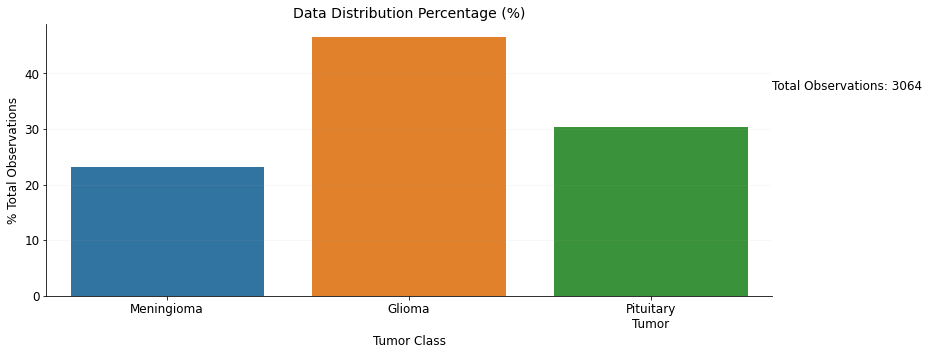

In [13]:
fig, axis = plt.subplots(figsize = (13, 5))
axis.grid(True, alpha = 0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize = 14)
sns.barplot(x = ['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index], 
            y = 100 * (data_distribution_count / data_distribution_count.sum()), ax = axis)
axis.set_xlabel("Tumor Class", fontsize = 12)
axis.set_ylabel("% Total Observations", fontsize = 12)
axis.tick_params(which = 'major', labelsize = 12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict = dict(size = 12))
sns.despine()

### **5.2 Visualisation of Brain MRI Dataset**

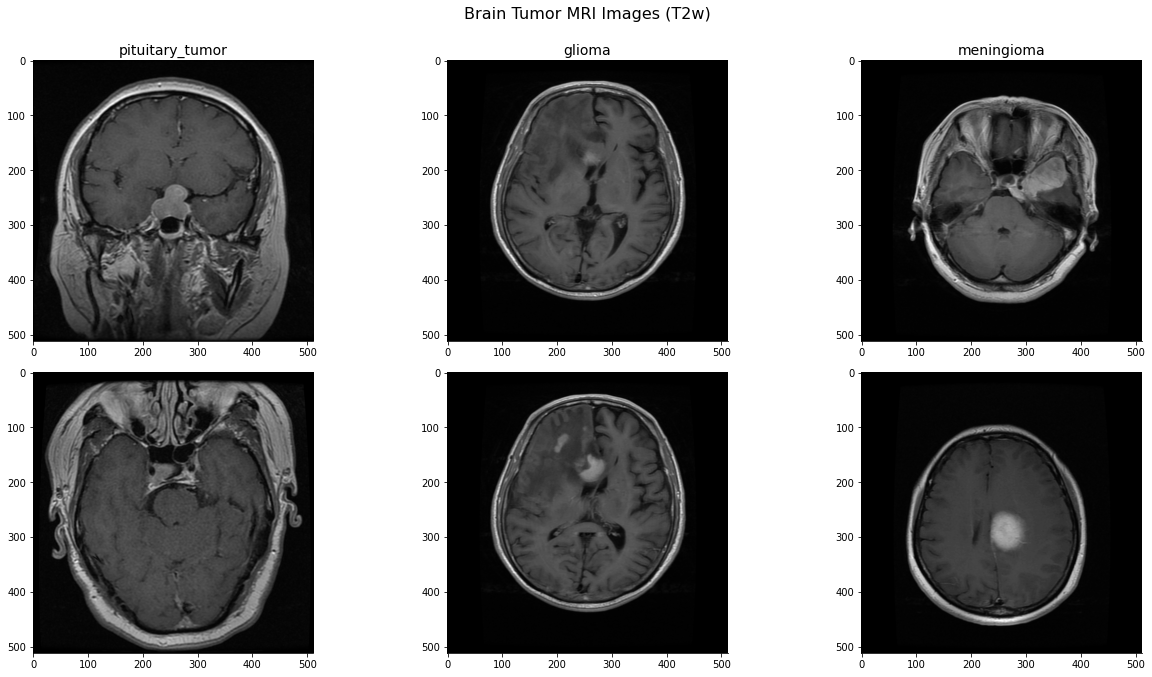

In [43]:
labels = set(df_images['class'])
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 9))
axes = axes.flatten()
fig.suptitle("Brain Tumor MRI Images (T2w)", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.04)
for i, curr_axis in zip( labels , axes[:3]):
    df_t =df_images.loc[df_images['class'] == i].reset_index(drop=True)
    curr_axis.imshow(df_t['image'][0], cmap = 'gray')
    curr_axis.set_title(df_t['class'][0], fontsize = 14)

for i, curr_axis in zip( labels , axes[3:]):
    df_t =df_images.loc[df_images['class'] == i].reset_index(drop=True)
    curr_axis.imshow(df_t['image'][1], cmap = 'gray')

fig.tight_layout()
sns.despine()
plt.show()

### **6. Development of Training, Validation & Testing Dataset**

In [61]:
image_data_paths = []
for curr_path, tumor_name in zip(IMAGE_DATA_PATHS, TUMOR_CLASS):
    if os.path.exists(curr_path) and os.path.isdir(curr_path):
        image_data_paths.extend(map(lambda filename: (os.path.join(curr_path, filename), tumor_name), os.listdir(curr_path)))

In [62]:
image_data_paths_df = pd.DataFrame(image_data_paths, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
image_data_paths_df.head()

,image_filepaths,tumor_class
0,/content/gdrive/MyDrive/Colab Notebooks/Brain ...,glioma
1,/content/gdrive/MyDrive/Colab Notebooks/Brain ...,meningioma
2,/content/gdrive/MyDrive/Colab Notebooks/Brain ...,glioma
3,/content/gdrive/MyDrive/Colab Notebooks/Brain ...,glioma
4,/content/gdrive/MyDrive/Colab Notebooks/Brain ...,glioma


In [63]:
image_data_paths_df.info()
train_data, validation_data = train_test_split(image_data_paths_df, 
                                               train_size = 0.80, 
                                               random_state = 42, 
                                               stratify = image_data_paths_df.tumor_class)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3064 entries, 0 to 3063
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_filepaths  3064 non-null   object
 1   tumor_class      3064 non-null   object
dtypes: object(2)
memory usage: 48.0+ KB


## **7. Data/Image Augmentation**


In [64]:
image_size = 128
batch_size = 32

image_datagen_kwargs = dict(rescale = 1 / 255,
                            rotation_range = 15, 
                            width_shift_range = 0.1, 
                            zoom_range = 0.01, 
                            shear_range = 0.01,
                            brightness_range = [0.3, 1.5],
                            horizontal_flip = True,
                            vertical_flip = True)

In [65]:
train_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
validation_image_datagen = ImageDataGenerator(**image_datagen_kwargs)

In [93]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data, 
                                                        x_col = 'image_filepaths', 
                                                        y_col = 'tumor_class', 
                                                        seed = 42, 
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')
validation_dataset = validation_image_datagen.flow_from_dataframe(validation_data, 
                                                                  x_col = 'image_filepaths', 
                                                                  y_col = 'tumor_class', 
                                                                  seed = 42,
                                                                  batch_size = batch_size, 
                                                                  target_size = (image_size, image_size),
                                                                  color_mode = 'rgb')


Found 2451 validated image filenames belonging to 3 classes.
Found 613 validated image filenames belonging to 3 classes.


In [94]:
print("Information about Training Dataset:")
print(train_dataset.class_indices)
print(train_dataset.image_shape, end = '\n\n')

Information about Training Dataset:
{'glioma': 0, 'meningioma': 1, 'pituitary_tumor': 2}
(128, 128, 3)



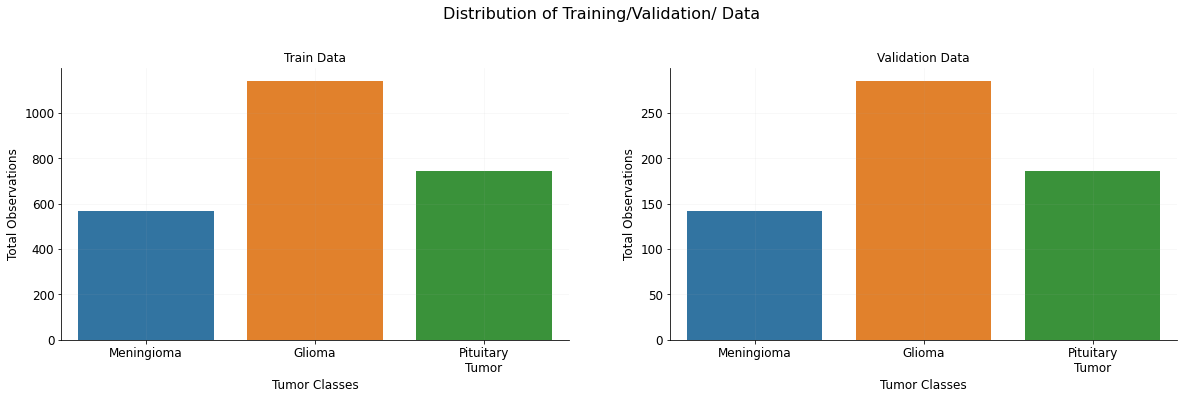

In [68]:
fig, axes = plt.subplots(ncols = 2, figsize = (20, 5))
fig.suptitle("Distribution of Training/Validation/ Data", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.05)
sns.countplot(x = train_data.tumor_class, order = TUMOR_CLASS, ax = axes[0])
sns.countplot(x = validation_data.tumor_class, order = TUMOR_CLASS, ax = axes[1])
for curr_axis, curr_title in zip(axes, ['Train Data', 'Validation Data']):
    curr_axis.grid(False, alpha = 0.1)
    curr_axis.set_title(curr_title, fontsize = 12)
    curr_axis.set_xlabel("Tumor Classes", fontsize = 12)
    curr_axis.set_ylabel("Total Observations", fontsize = 12)
    curr_axis.tick_params(which = 'major', labelsize = 12)
    curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in TUMOR_CLASS])
sns.despine()
     

## **8. Model Development**

In [73]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10,mode='min')

In [74]:
def training_process_viz(training_stats: pd.DataFrame, **plot_kwargs) -> None:
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    fig.suptitle(plot_kwargs['plot_title'], fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.08)
    for curr_axis, col_name in zip(axes, ['accuracy', 'loss']):
        curr_axis.grid(True, alpha = 0.3)
        curr_axis.set_title(f"Model {col_name}".title(), fontsize = 14)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[col_name], color = 'blue', ax = curr_axis)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[f"val_{col_name}"], color = 'red', ax = curr_axis)
        curr_axis.set_xlabel("Epochs", fontsize = 12)
        curr_axis.set_ylabel(col_name.title(), fontsize = 12)
        curr_axis.tick_params(which = 'major', labelsize = 12)
        curr_axis.legend([col_name.title(), f"validation {col_name}".title()], title = col_name.title())
    fig.tight_layout()
    sns.despine()

In [75]:
def generate_report(*models, test_dataset, row_indexes) -> pd.DataFrame:
    assert len(models)
    report_df = pd.DataFrame(columns = ['Loss', 'Accuracy','Precison','Recall', 'F1-Score'])
    y_hat = test_dataset.classes 
    for curr_index, curr_model in enumerate(models):
        assert isinstance(curr_model, Sequential)
        curr_model_loss, curr_model_accuracy = curr_model.evaluate(test_dataset)
        y_preds = [np.argmax(curr_preds) for curr_preds in curr_model.predict(test_dataset)]
        report_df.loc[curr_index] = [ curr_model_loss, curr_model_accuracy,precision_score(y_hat, y_preds, average = "micro"),recall_score(y_hat, y_preds, average = "micro"), f1_score(y_hat, y_preds, average = "micro")]
    report_df.index = row_indexes
    return report_df

### **8.1 ResNet**

#### **8.1.1 Developement of ResNet**

In [76]:
from tensorflow.keras.applications.resnet50 import ResNet50
resnet_model = ResNet50(weights = 'imagenet',include_top = False, 
                                 input_shape = (image_size, image_size, 3))
for i in range(len(resnet_model.layers)):
      resnet_model.layers[i].trainable = False
resnet_model.layers[-1].trainable=True

In [77]:
resnet_cnn_model = Sequential()
resnet_cnn_model.add(resnet_model)
resnet_cnn_model.add(Flatten(name = 'Flatten-Layer-1'))
resnet_cnn_model.add(Dense(256, activation = 'relu', name = 'Hidden-Layer-1'))
resnet_cnn_model.add(Dropout(rate = 0.3, name = 'Dropout-Layer-1'))
resnet_cnn_model.add(Dense(64, activation = 'relu', name = 'Hidden-Layer-2'))
resnet_cnn_model.add(Dropout(rate = 0.3, name = 'Dropout-Layer-2'))
resnet_cnn_model.add(Dense(3, activation = 'softmax', name = 'Output-Layer'))
resnet_cnn_model.compile(optimizer = Adam(0.0003), loss = 'categorical_crossentropy', metrics = ['accuracy'])
resnet_cnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 Flatten-Layer-1 (Flatten)   (None, 32768)             0         
                                                                 
 Hidden-Layer-1 (Dense)      (None, 256)               8388864   
                                                                 
 Dropout-Layer-1 (Dropout)   (None, 256)               0         
                                                                 
 Hidden-Layer-2 (Dense)      (None, 64)                16448     
                                                                 
 Dropout-Layer-2 (Dropout)   (None, 64)                0         
                                                                 
 Output-Layer (Dense)        (None, 3)               

#### **8.1.2 Training and Validation of Resnet Model**

In [95]:
resnet_model_train_history = resnet_cnn_model.fit(train_dataset, 
                                                            batch_size = batch_size,
                                                            validation_data = validation_dataset, 
                                                            epochs = 200,callbacks = [early_stopping])

Epoch 1/200
35/77 [============>.................] - ETA: 39s - loss: 1.0503 - accuracy: 0.4788

KeyboardInterrupt: ignored

#### **8.1.3 ResNet Model Training Process Statistics**

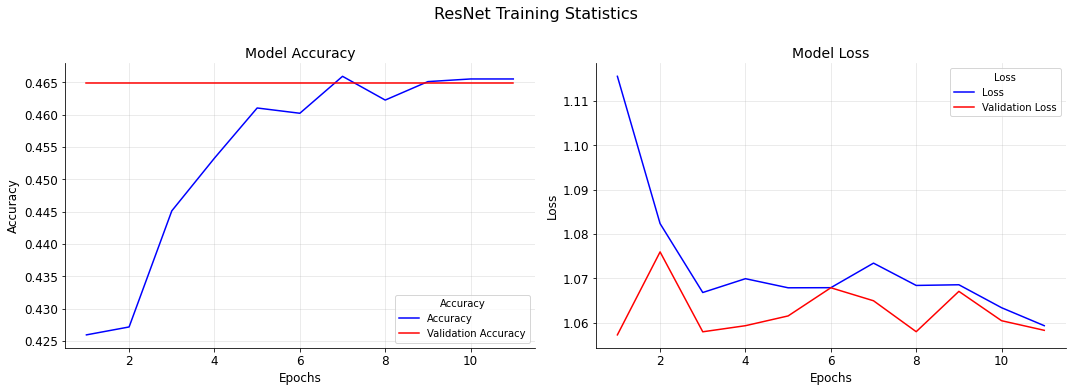

In [79]:
training_process_viz(pd.DataFrame(resnet_model_train_history.history), 
                     plot_title = 'ResNet Training Statistics')

In [80]:
resnet_report_df = generate_report(resnet_cnn_model, test_dataset = validation_dataset, row_indexes = ['ResNet'])
resnet_report_df

20/20 [==============================] - 17s 795ms/step


,Loss,Accuracy,Precison,Recall,F1-Score
ResNet,1.058261,0.464927,0.464927,0.464927,0.464927


### **8.2 AlexNet CNN**

#### **8.2.1 Develoment of AlexNet CNN Model**

In [81]:
alexnet_cnn = Sequential()
alexnet_cnn.add(Conv2D(96, kernel_size = 11, strides = 4, activation = 'relu', input_shape = (image_size, image_size, 3), name = 'Conv2D-1'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-1'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-1'))
alexnet_cnn.add(Conv2D(256, kernel_size = 5, padding = 'same', activation = 'relu', name = 'Conv2D-2'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-2'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-2'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-3'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-3'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-4'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-4'))
alexnet_cnn.add(Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-5'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-5'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-3'))
alexnet_cnn.add(Flatten(name = 'Flatten-Layer-1'))
alexnet_cnn.add(Dense(128, activation = 'relu', name = 'Hidden-Layer-1'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-1'))
alexnet_cnn.add(Dense(64, activation = 'relu', name = 'Hidden-Layer-2'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-2'))
alexnet_cnn.add(Dense(3, activation = 'softmax', name = 'Output-Layer'))
optimizer = keras.optimizers.Adam(lr=0.03)
alexnet_cnn.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
alexnet_cnn.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D-1 (Conv2D)           (None, 30, 30, 96)        34944     
                                                                 
 Batch-Normalization-1 (Batc  (None, 30, 30, 96)       384       
 hNormalization)                                                 
                                                                 
 Max-Pooling-1 (MaxPooling2D  (None, 14, 14, 96)       0         
 )                                                               
                                                                 
 Conv2D-2 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 Batch-Normalization-2 (Batc  (None, 14, 14, 256)      1024      
 hNormalization)                                                 
                                                     

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### **8.2.2 Training and Validation of AlexNet CNN Model**

In [82]:
alexnet_train_history = alexnet_cnn.fit(train_dataset, 
                                            batch_size = batch_size,
                                            validation_data = validation_dataset, 
                                            epochs = 100,callbacks = [early_stopping])

Epoch 1/100
77/77 [==============================] - 83s 1s/step - loss: 3.3779 - accuracy: 0.4447 - val_loss: 1.0581 - val_accuracy: 0.4649
Epoch 2/100
77/77 [==============================] - 82s 1s/step - loss: 1.0911 - accuracy: 0.4631 - val_loss: 1.0599 - val_accuracy: 0.4649
Epoch 3/100
77/77 [==============================] - 80s 1s/step - loss: 1.0899 - accuracy: 0.4631 - val_loss: 1.0570 - val_accuracy: 0.4649
Epoch 4/100
77/77 [==============================] - 80s 1s/step - loss: 1.0628 - accuracy: 0.4659 - val_loss: 1.0570 - val_accuracy: 0.4649
Epoch 5/100
77/77 [==============================] - 81s 1s/step - loss: 1.0876 - accuracy: 0.4647 - val_loss: 1.0576 - val_accuracy: 0.4649
Epoch 6/100
77/77 [==============================] - 79s 1s/step - loss: 1.0784 - accuracy: 0.4647 - val_loss: 1.0575 - val_accuracy: 0.4649
Epoch 7/100
77/77 [==============================] - 82s 1s/step - loss: 1.0694 - accuracy: 0.4663 - val_loss: 1.0575 - val_accuracy: 0.4649
Epoch 8/100
7

#### **8.2.3 AlexNet CNN Model Training Process Statistics**

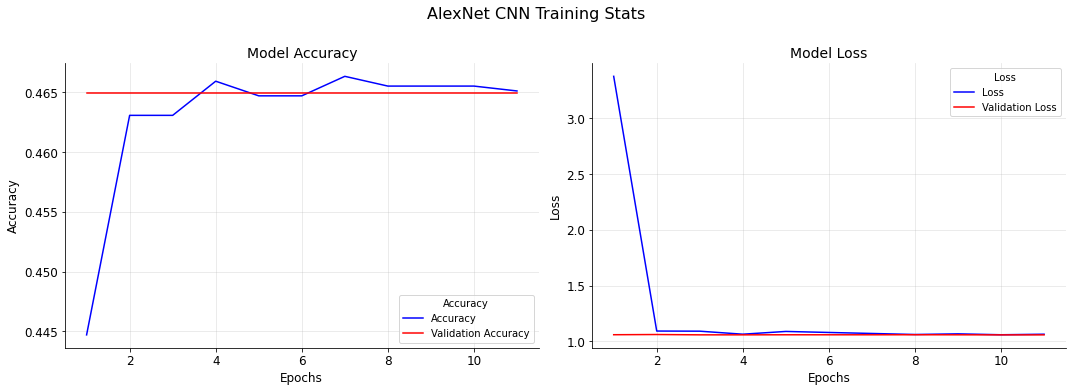

In [83]:
training_process_viz(pd.DataFrame(alexnet_train_history.history), plot_title = 'AlexNet CNN Training Stats')

In [84]:
alexnet_report_df = generate_report(alexnet_cnn, test_dataset = validation_dataset, row_indexes = ['AlexNet CNN'])
alexnet_report_df

20/20 [==============================] - 16s 789ms/step


,Loss,Accuracy,Precison,Recall,F1-Score
AlexNet CNN,1.05679,0.464927,0.464927,0.464927,0.464927


### **8.3 Multi-Layer Perceptron**

#### **8.3.1 Development of Multi-Layer Perceptron Model**

In [85]:
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape = (image_size, image_size, 3), name = 'Flatten-Layer'))
mlp_model.add(Dense(2048, activation = 'relu', name = 'Hidden-Layer-1'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-1'))
mlp_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-2'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-2'))
mlp_model.add(Dense(512, activation = 'relu', name = 'Hidden-Layer-3'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-3'))
mlp_model.add(Dense(3, activation = 'softmax', name = 'Output-Layer-1'))
mlp_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
mlp_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten-Layer (Flatten)     (None, 49152)             0         
                                                                 
 Hidden-Layer-1 (Dense)      (None, 2048)              100665344 
                                                                 
 Dropout-Layer-1 (Dropout)   (None, 2048)              0         
                                                                 
 Hidden-Layer-2 (Dense)      (None, 1024)              2098176   
                                                                 
 Dropout-Layer-2 (Dropout)   (None, 1024)              0         
                                                                 
 Hidden-Layer-3 (Dense)      (None, 512)               524800    
                                                                 
 Dropout-Layer-3 (Dropout)   (None, 512)             

#### **8.3.2 Training and Validation of Multi-Layer Perceptron Based Model**

In [86]:
mlp_train_history = mlp_model.fit(train_dataset,
                                      batch_size = batch_size,
                                      validation_data = validation_dataset,
                                      epochs = 100,callbacks = [early_stopping])

Epoch 1/100
77/77 [==============================] - 83s 1s/step - loss: 10.4070 - accuracy: 0.3729 - val_loss: 1.0973 - val_accuracy: 0.3034
Epoch 2/100
77/77 [==============================] - 79s 1s/step - loss: 1.0978 - accuracy: 0.4480 - val_loss: 1.0623 - val_accuracy: 0.4649
Epoch 3/100
77/77 [==============================] - 81s 1s/step - loss: 1.0583 - accuracy: 0.4655 - val_loss: 1.0568 - val_accuracy: 0.4649
Epoch 4/100
77/77 [==============================] - 81s 1s/step - loss: 1.0568 - accuracy: 0.4655 - val_loss: 1.0568 - val_accuracy: 0.4649
Epoch 5/100
77/77 [==============================] - 81s 1s/step - loss: 1.0580 - accuracy: 0.4655 - val_loss: 1.0568 - val_accuracy: 0.4649
Epoch 6/100
77/77 [==============================] - 80s 1s/step - loss: 1.0562 - accuracy: 0.4655 - val_loss: 1.0569 - val_accuracy: 0.4649
Epoch 7/100
77/77 [==============================] - 82s 1s/step - loss: 1.0570 - accuracy: 0.4655 - val_loss: 1.0575 - val_accuracy: 0.4649
Epoch 8/100


#### **8.3.3 Multi-Layer Perceptron Based Model Training Process Statistics**

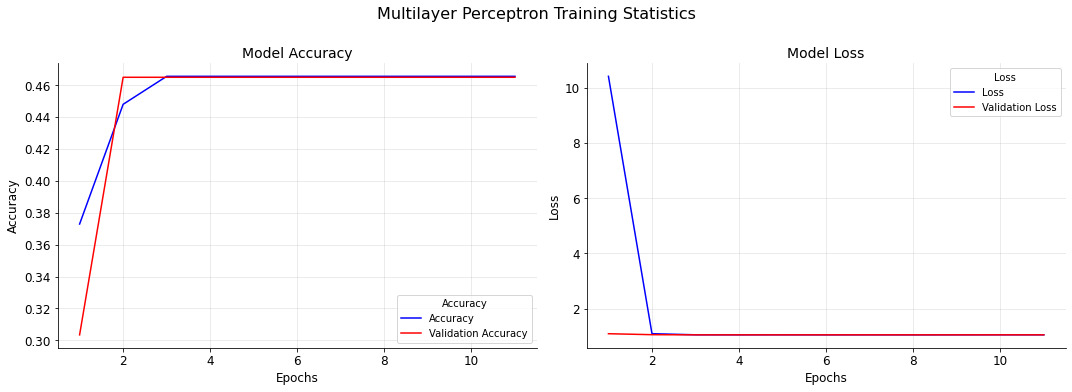

In [87]:
training_process_viz(pd.DataFrame(mlp_train_history.history), 
                     plot_title = 'Multilayer Perceptron Training Statistics')

In [88]:
mlp_report_df = generate_report(mlp_model, 
                                test_dataset = validation_dataset, 
                                row_indexes = ("Multi-Layer-Perceptron Model",))
mlp_report_df

20/20 [==============================] - 16s 804ms/step


,Loss,Accuracy,Precison,Recall,F1-Score
Multi-Layer-Perceptron Model,1.057023,0.464927,0.464927,0.464927,0.464927


## **9. Conclusions**

* The **pre-trained (imagenet) ResNet** model has performed the best among Multi-Layer perceptron and AlexNet CNN models with an accuracy of $82.57\%$ 

In [89]:
final_report_df = pd.concat([mlp_report_df, alexnet_report_df, resnet_report_df])
final_report_df

,Loss,Accuracy,Precison,Recall,F1-Score
Multi-Layer-Perceptron Model,1.057023,0.464927,0.464927,0.464927,0.464927
AlexNet CNN,1.056790,0.464927,0.464927,0.464927,0.464927
ResNet,1.058261,0.464927,0.464927,0.464927,0.464927
